# Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# read data into dataframes
df_conversion = pd.read_csv('Conversion_data.csv')
df_nonconversion = pd.read_csv('nonconversion_data.csv')

# add an additional column to label data as conversion or nonconversion
df_conversion.insert(7, 'conversion?', [1] * len(df_conversion), True)
df_nonconversion.insert(7, 'conversion?', [0] * len(df_nonconversion), True)

# concat the two dataframes
frames = [df_conversion, df_nonconversion]
df = pd.concat(frames)

# relabel the columns
df.columns = ['Site', 'Format', 'Browser', 'Vendor', 'Metro', 'OS', 'Hours', 'Conversion']

# Functions for Calculations

## Function Definitions

I labeled arguments as `numerical_var` to include data points that are not strictly continuous (such as Conversion).

In [3]:
def continuous_stats(data, numerical_var):
    """
    Generate descriptive statistics for continuous & numerical variables

    Args:
        data (dataframe): the dataframe with the data
        numerical_var (string): the numerical var you want stats for

    Returns:
        dataframe with mean, median, std dev, skew, and kurtosis
    """
    
    # calculate stats
    mean = data[numerical_var].mean()
    median = data[numerical_var].median()
    std_dev = data[numerical_var].std()
    skew = data[numerical_var].skew()
    kurtosis = data[numerical_var].kurtosis()

    # build dataframe
    stats = pd.DataFrame({'Mean': [mean], 'Median': [median], 'Std Dev': [std_dev],
                          'Skew': [skew], 'Kurtosis': [kurtosis]},
                           index=[numerical_var])
    return(stats)

In [4]:
def continuous_stats_by_category(data, numerical_var, categorical_var):
    """
    Generate count, mean, std dev, and percentiles for a level of categorical var 
    (e.g. 'price by zipcode')

    Args:
        data (dataframe): the dataframe with the data
        numerical_var (str): the 'level' of the categorical variable (you may use 
            this on hours, metro, and conversion)
        categorical_var (str): the categorical variable you want stats for
    
    Returns:
        dataframe
    """
    # grab data subset
    filtered_data = data.groupby(categorical_var)[numerical_var]
    stats = filtered_data.describe()

    # add columns for skew and kurtosis
    stats['Skew'] = filtered_data.apply(lambda x: x.skew())
    stats['Kurtosis'] = filtered_data.apply(lambda x: x.kurtosis())

    # reorganize
    stats.drop(columns = ['count', 'min', '25%', '75%', 'max'], inplace = True)
    stats.columns = ['Mean', 'Std Dev', 'Median', 'Skew', 'Kurtosis']
    
    return stats 

In [5]:
def graph_by_mean(data, categorical_var, numerical_var, start, end):
    """
    Plot the mean of a continuous var for a categorical var (e.g. hours per metro)

    Args:
        data (dataframe)
        categorical_var (str)
        numerical_var (str)
        start (int): start index to select categorical_vars
        end (int): end index (non-inclusive)
    """
    # sort data and grab requested subset
    means = data.groupby(categorical_var)[numerical_var].mean()
    means_sorted = means.sort_index(ascending = True)
    subset = means_sorted.iloc[start:end]
    
    # create plot
    plt.bar(subset.index, subset)
    plt.xlabel(categorical_var)
    plt.ylabel(f"Mean {numerical_var}")
    plt.title(f"Mean {numerical_var} by {categorical_var}")

    # format to make large data sets more readable
    plt.xticks(rotation=45, ha='right')
    
    plt.show()

## Applications of Above Functions

Here are a few examples of the above functions. 

In [6]:
continuous_stats(df, 'Hours')

,Mean,Median,Std Dev,Skew,Kurtosis
Hours,87.539098,77.0,43.836813,0.161422,-0.863701


In [7]:
continuous_stats(df, 'Conversion')

,Mean,Median,Std Dev,Skew,Kurtosis
Conversion,0.25,0.0,0.433013,1.154705,-0.66666


In [8]:
continuous_stats_by_category(df, 'Hours', 'OS')

,Mean,Std Dev,Median,Skew,Kurtosis
OS,,,,,
Android,92.904056,46.847560,84.0,-0.067406,-1.063163
Linux,85.290105,40.928672,78.0,0.134060,-0.638487
OS X,83.808058,42.014867,72.0,0.159890,-0.748928
Other,77.443939,38.740781,65.0,0.730223,0.062806
Windows,82.416110,40.267986,69.0,0.407801,-0.484039
iOS,91.149895,44.866002,88.0,-0.026132,-0.859058


In [9]:
continuous_stats_by_category(df, 'Conversion', 'Metro').head()

,Mean,Std Dev,Median,Skew,Kurtosis
Metro,,,,,
0.0,0.605263,0.492042,1.0,-0.439426,-1.856478
500.0,0.222013,0.415796,0.0,1.339653,-0.205721
501.0,0.131437,0.337886,0.0,2.181793,2.760490
502.0,0.127430,0.333815,0.0,2.241883,3.039149
503.0,0.421233,0.494604,0.0,0.320702,-1.910282


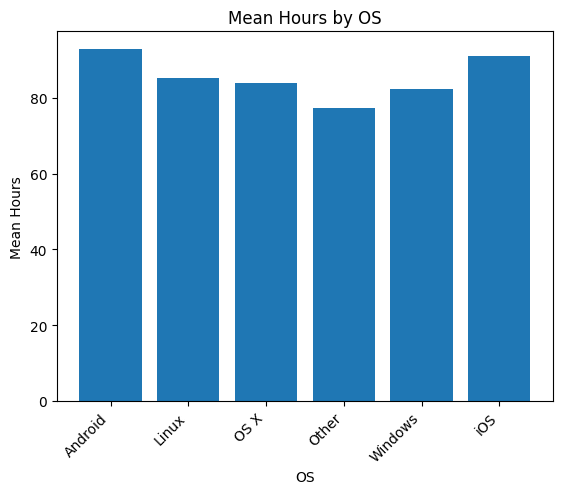

In [10]:
graph_by_mean(df, 'OS', 'Hours', 0, 6)

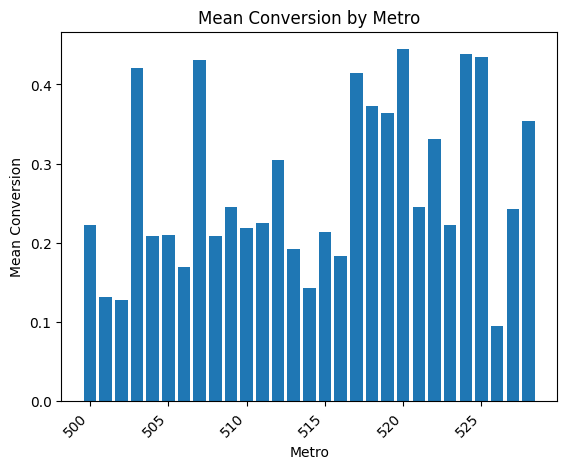

In [11]:
graph_by_mean(df, 'Metro', 'Conversion', 1, 30)

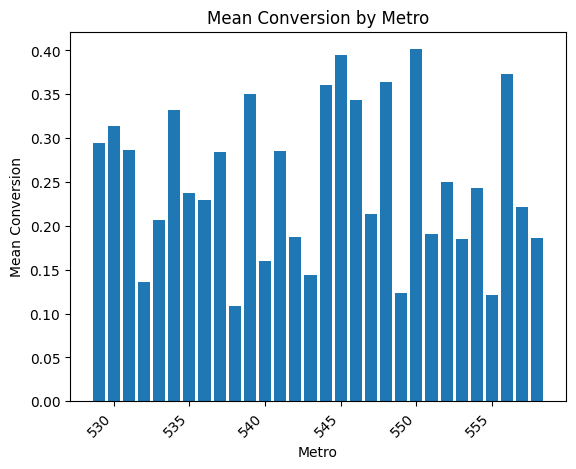

In [12]:
graph_by_mean(df, 'Metro', 'Conversion', 30, 60)

# Data Classification Model

## Process and Split Data

In [13]:
# extract feature and target arrays
X = df.drop('Conversion', axis=1)
y = df[['Conversion']]

# convert categorical variables to category type (instead of object)
cat_vars = ['Site', 'Format', 'Browser', 'Vendor', 'Metro', 'OS']
for c in cat_vars:
    X[c] = X[c].astype('category')

# split the data into train and test sets (default 0.25 test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Print Metrics Function

In [14]:
def print_evaluation(y_test, preds):
    # ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    
    # convert predictions to binary to calculate remaining metrics
    for index, item in enumerate(preds, start = 0):
        preds[index] = item.round()
        
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    # accuracy, precision, recall, f1
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    # print all stats
    print('  MODEL METRICS')
    print('-----------------')
    print(f"RMSE:      {rmse:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print()
    
    # plotting ROC
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Pos Rate')
    plt.ylabel('True Pos Rate')
    plt.show()

## Method 1: Using DMatrix in XGBoost

  MODEL METRICS
-----------------
RMSE:      0.3942
Accuracy:  0.8446
Precision: 0.7573
Recall:    0.5566
F1 Score:  0.6416
ROC AUC:   0.8852



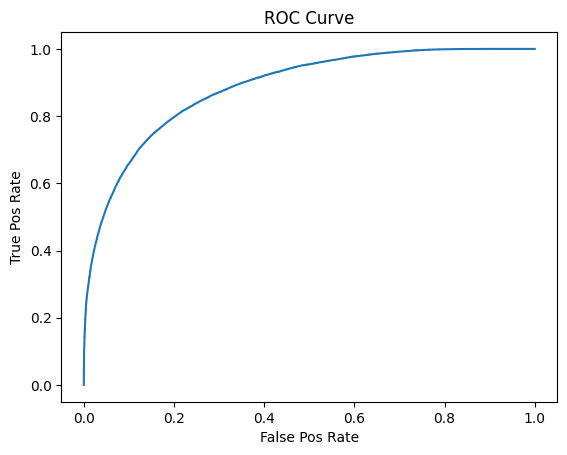

In [15]:
# convert to DMatrix format
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical = True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical = True)

# define parameters (note that conversion is binary)
params = {"objective": "binary:logistic", "tree_method": "hist"}

# train
model = xgb.train(params = params, dtrain = dtrain_reg, num_boost_round = 100)

# predict
preds = model.predict(dtest_reg)

# evaluate the model
print_evaluation(y_test, preds)

## Analysis of DMatrix Model

This model is successful overall; it is able to accurately classify around 84% of the data set. The high ROC AUC demonstrates that the model can accurately distinguish between positive and negative instances. However, its largest weakness is the recall metric, implying that the model struggles to identify all cases of conversion. As a result, applying this model means that not all conversion opportunities are identified and thus fewer potential customers are targeted.

## Method 2: Using GridSearchCV from scikit-learn

In [16]:
# specify constants
estimator = XGBClassifier(
    objective = 'binary:logistic',
    nthread = 4,
    seed = 42,
    enable_categorical=True
)

# set tunable parameters (Note: I could not do a large amount of tuning on my laptop)
parameters = {
    'max_depth': [3, 5],
    'n_estimators': [100],
    'learning_rate': [0.1, 0.05]
}

# perform grid search; compare hyperparameters based on ROC AUC
grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)

# train
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [3, 5],
                         'n_estimators': [100]},
             scoring='roc_auc')

    PARAMETERS
------------------
Learning Rate: 0.1
Max Depth:     5
N Estimators:  100

  MODEL METRICS
-----------------
RMSE:      0.3983
Accuracy:  0.8414
Precision: 0.7960
Recall:    0.4910
F1 Score:  0.6074
ROC AUC:   0.7246



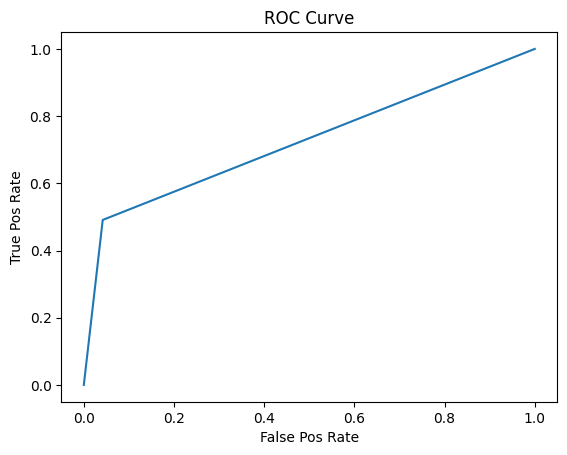


  FEATURE IMPORTANCES
-----------------------


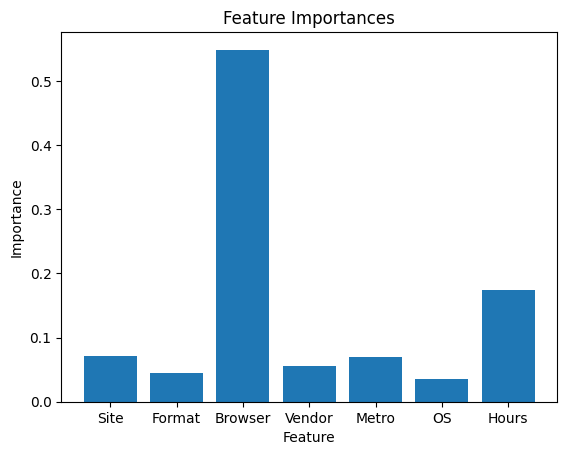

In [17]:
# print best parameters
best_params = grid_search.best_params_
print('    PARAMETERS')
print('------------------')
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Max Depth:     {best_params['max_depth']}")
print(f"N Estimators:  {best_params['n_estimators']}")
print()

# save best estimator
best_estimator = grid_search.best_estimator_

# predict
preds = best_estimator.predict(X_test)

# evaluate the model
print_evaluation(y_test, preds)

# feature importances
feature_importances = best_estimator.feature_importances_

print()
print('  FEATURE IMPORTANCES')
print('-----------------------')

plt.bar(['Site', 'Format', 'Browser', 'Vendor', 'Metro', 'OS', 'Hours'], feature_importances)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Analysis of GridSearchCV Model

The GridSearchCV Model performed similarly to the DMatrix Model, but the recall was slightly worse. This model could be more effective if the grid search consisted of more parameter values. With this model, I was able to look at feature importances, which yielded that the browser had significantly more impact on the model's output. Different browsers offer varying user experiences -- for example, browser features such as speed, security, and ad-blocking vary and could impact the conversion. 

## Additional Thoughts

Data suitability could be improved by adding more information on user demographics and product types. For example, the websites provided could be sorted based on category (e.g. online clothing shopping, online games) in order to better assess what websites the target demographic would be on. It would also be extremely useful to include data on the users themselves and whether they had prior exposure to the company's products.